***В данной работе я, по средствам машинного обучения, буду прогнозировать количество поездок в час по разным округам г.Чикаго(США), основываясь на имеющихся данных за 2022 год.*** 

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext, DataFrameStatFunctions, DataFrameNaFunctions, Window

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, lit, length, count, transform, round, lag, sequence, explode

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor, LinearRegression, RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from multiprocessing.pool import ThreadPool

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
random_state = 42

In [4]:
sns.set_style('whitegrid')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
SPARK_MASTER_IP = ''

spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}") \
    .config("", 1) \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

In [7]:
sc = spark.sparkContext

In [8]:
sqlContext = SQLContext(spark.sparkContext)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [9]:
house = 'Taxi_Trips_-_2022.csv'

In [10]:
schema = StructType([
    StructField('Trip ID', StringType(), nullable=True),
    StructField('Taxi ID', StringType(), nullable=True),
    StructField('Trip Start Timestamp', StringType(), nullable=True),
    StructField('Trip End Timestamp', StringType(), nullable=True),
    StructField('Trip Seconds', FloatType(), nullable=True),
    StructField('Trip Miles', FloatType(), nullable=True),
    StructField('Pickup Census Tract', FloatType(), nullable=True),
    StructField('Dropoff Census Tract', FloatType(), nullable=True),
    StructField('Pickup Community Area', StringType(), nullable=True),
    StructField('Dropoff Community Area', IntegerType(), nullable=True),
    StructField('Fare', FloatType(), nullable=True),
    StructField('Tips', FloatType(), nullable=True),
    StructField('Tolls', FloatType(), nullable=True),
    StructField('Extras', FloatType(), nullable=True),
    StructField('Trip Total', FloatType(), nullable=True),
    StructField('Payment Type', StringType(), nullable=True),
    StructField('Company', StringType(), nullable=True),
    StructField('Pickup Centroid Latitude', FloatType(), nullable=True),
    StructField('Pickup Centroid Longitude', FloatType(), nullable=True),
    StructField('Pickup Centroid Location', StringType(), nullable=True),
    StructField('Dropoff Centroid Latitude', FloatType(), nullable=True),
    StructField('Dropoff Centroid Longitude', FloatType(), nullable=True),
    StructField('Dropoff Centroid  Location', StringType(), nullable=True)
])

In [11]:
raw_df = spark.read.csv(path=house, schema=schema, header=True).cache()

In [12]:
raw_df = raw_df.withColumn('Trip Start Timestamp', F.to_timestamp(F.col('Trip Start Timestamp'),
                                                          'MM/dd/yyyy hh:mm:ss a'))
raw_df = raw_df.withColumn('Trip End Timestamp', F.to_timestamp(F.col('Trip End Timestamp'),
                                                          'MM/dd/yyyy hh:mm:ss a'))

In [13]:
raw_df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: float (nullable = true)
 |-- Trip Miles: float (nullable = true)
 |-- Pickup Census Tract: float (nullable = true)
 |-- Dropoff Census Tract: float (nullable = true)
 |-- Pickup Community Area: string (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Tips: float (nullable = true)
 |-- Tolls: float (nullable = true)
 |-- Extras: float (nullable = true)
 |-- Trip Total: float (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: float (nullable = true)
 |-- Pickup Centroid Longitude: float (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: float (nullable = true)
 |-- Dropoff Centroid Long

In [14]:
raw_df.head(1)

[Row(Trip ID='bcfa19f2539021c054809d4c3993d226996ae095', Taxi ID='368ce5511598af2cc07efdb68067d381174fdac1d47a2837d021e647f4c8febb3d9bf330e155845b8217b9b451c29b1b9ecf5d55d4bfe6cfd5d79ffb49b1f334', Trip Start Timestamp=datetime.datetime(2022, 1, 1, 0, 0), Trip End Timestamp=datetime.datetime(2022, 1, 1, 0, 0), Trip Seconds=152.0, Trip Miles=0.10000000149011612, Pickup Census Tract=None, Dropoff Census Tract=None, Pickup Community Area=None, Dropoff Community Area=None, Fare=3.75, Tips=0.0, Tolls=0.0, Extras=0.0, Trip Total=3.75, Payment Type='Cash', Company='Medallion Leasin', Pickup Centroid Latitude=None, Pickup Centroid Longitude=None, Pickup Centroid Location=None, Dropoff Centroid Latitude=None, Dropoff Centroid Longitude=None, Dropoff Centroid  Location=None)]

In [15]:
for z in raw_df.columns:
    print(z, raw_df[raw_df[z].isNull()].count())

Trip ID 0
Taxi ID 0
Trip Start Timestamp 0
Trip End Timestamp 212
Trip Seconds 1465
Trip Miles 56
Pickup Census Tract 3758594
Dropoff Census Tract 3707094
Pickup Community Area 513853
Dropoff Community Area 633684
Fare 3536
Tips 3536
Tolls 3536
Extras 3536
Trip Total 3536
Payment Type 0
Company 0
Pickup Centroid Latitude 511551
Pickup Centroid Longitude 511551
Pickup Centroid Location 511551
Dropoff Centroid Latitude 597931
Dropoff Centroid Longitude 597931
Dropoff Centroid  Location 597931


In [16]:
raw_df.count()

6382425

In [17]:
len(raw_df.columns)

23

- Я открыла датасет, содержащий 6 382 425 записей и 23 столбца с данными о поездках в такси. 23 столбца содержат численный тип данных, 2 тип временной метки, 8 строковый. В 18 столбцах существуют пропуски.
- Сразу приведу названия столбцов в неразрывный формат и разделю столбцы по типу данных
- Пропуски в данных касательно метки округа, где началась поездка, заполню заглушкой-***0***, так как эти пропуски касаются поездок, начавшихся за городской чертой и не имеющих цифровой метки города
- Строки с пропусками в данных, касательно времени окончания поездки и финансов удалю, так как они составляют менее 1% от всех данных
- Целевой переменной в данной задаче является количество поездок, для ее формирования введу в данные столбец ***num_orders***, характеризующий количество уникальных поездок.

In [18]:
raw_df = raw_df.withColumnsRenamed({'Trip Start Timestamp': 'Trip_Start_Timestamp', 'Trip End Timestamp': 'Trip_End_Timestamp',
    'Trip Seconds': 'Trip_Seconds', 'Trip Miles': 'Trip_Miles', 'Pickup Community Area': 'Pickup_Community_Area',
    'Dropoff Community Area': 'Dropoff_Community_Area', 'Trip Total': 'Trip_Total', 'Payment Type': 'Payment_Type'})

In [19]:
raw_df = raw_df.na.fill({'Pickup_Community_Area': '0'})
raw_df = raw_df.na.drop(subset=['Trip_End_Timestamp', 'Trip_Seconds', 'Trip_Miles', 'Fare'], how='any')

In [20]:
raw_df = raw_df.withColumn('num_orders', lit(1))

In [21]:
num_cols = []
date_cols = []
cat_cols = []
for x in raw_df.dtypes:
    if x[1]=='float' or x[1]=='integer':
        num_cols.append(x[0])
    elif x[1]=='timestamp':
        date_cols.append(x[0])
    else:
        cat_cols.append(x[0])

***Разведовательный анализ признаков, относящихся к временным меткам и месту начала поездки.***

***1)*** выделю часы, дни недели, даты, месяцы из имеющихся временных меток в данных о начале каждой поездки и посмотрю на распределения целевой переменной.

In [22]:
raw_df = raw_df.withColumn('hour', F.hour('Trip_Start_Timestamp'))
raw_df = raw_df.withColumn('day_week', F.dayofweek('Trip_Start_Timestamp'))
raw_df = raw_df.withColumn('day_month', F.dayofmonth('Trip_Start_Timestamp'))
raw_df = raw_df.withColumn('month', F.month('Trip_Start_Timestamp'))

In [23]:
sort_hour = raw_df.groupby('hour').count().sort('hour').toPandas()
sort_dayweek = raw_df.groupby('day_week').count().sort('day_week').toPandas()
sort_daymonth = raw_df.groupby('day_month').count().sort('day_month').toPandas()
sort_month = raw_df.groupby('month').count().sort('month').toPandas()

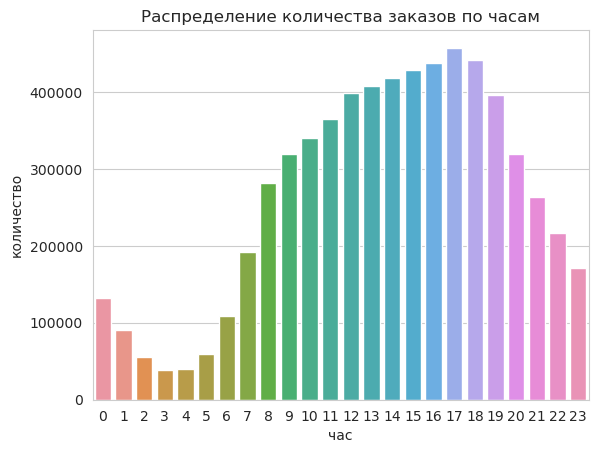

In [24]:
sns.barplot(data=sort_hour, x='hour', y='count')
plt.xlabel('час')
plt.ylabel('количество')
plt.title('Распределение количества заказов по часам');

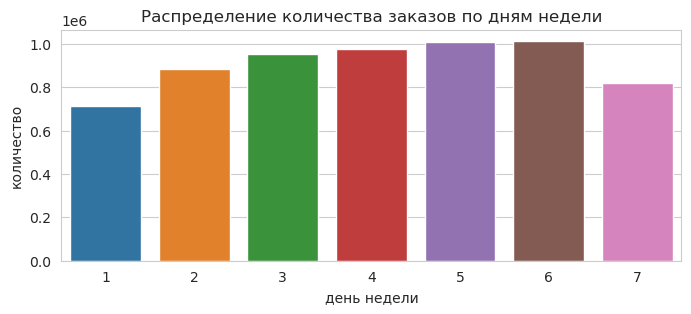

In [25]:
plt.figure(figsize=(8, 3))
sns.barplot(data=sort_dayweek, x='day_week', y='count')
plt.xlabel('день недели')
plt.ylabel('количество')
plt.title('Распределение количества заказов по дням недели');

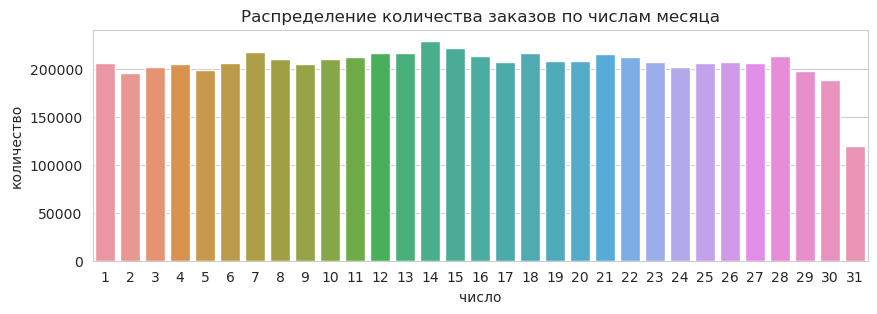

In [26]:
plt.figure(figsize=(10, 3))
sns.barplot(data=sort_daymonth, x='day_month', y='count')
plt.xlabel('число')
plt.ylabel('количество')
plt.title('Распределение количества заказов по числам месяца');

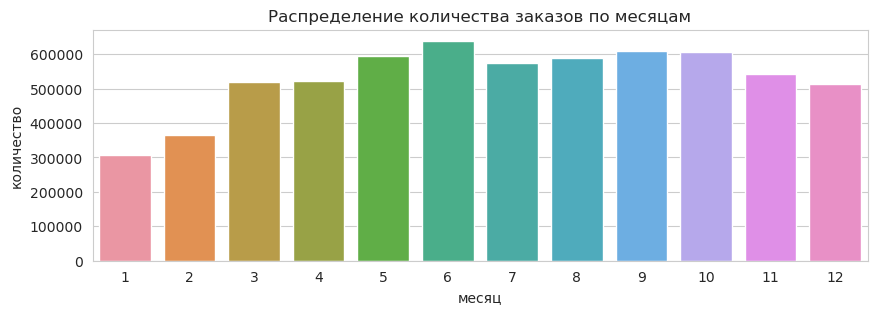

In [27]:
plt.figure(figsize=(10, 3))
sns.barplot(data=sort_month, x='month', y='count')
plt.xlabel('месяц')
plt.ylabel('количество')
plt.title('Распределение количества заказов по месяцам');

***Выводы:***
 1) больше всего заказов приходится на 18-19 часов, меньше всего на 3-4
 2) распределение количества заказов возрастает от понедельника к пятнице и субботе(максимальный уровень), в воскресеньe снижается
 3) распределение количества заказов по датам в принципе равномерное(учитывая, что 31 число есть не в каждом месяце)
 4) количество заказов по месяцам растет с января по июнь(максимум), после сентября начинаеся плавный спад.

***2)*** Также я визуализирую распределение количества заказов по городским округам. В колонке с данными по округу, где осуществлялась посадка клиентов, есть данные, не относящиеся ни к одному из 77 округов, скорее посадка осуществлялась за переделами городской черты(0).

In [28]:
sort_area = raw_df.groupby('Pickup_Community_Area').count().sort('Pickup_Community_Area').toPandas()

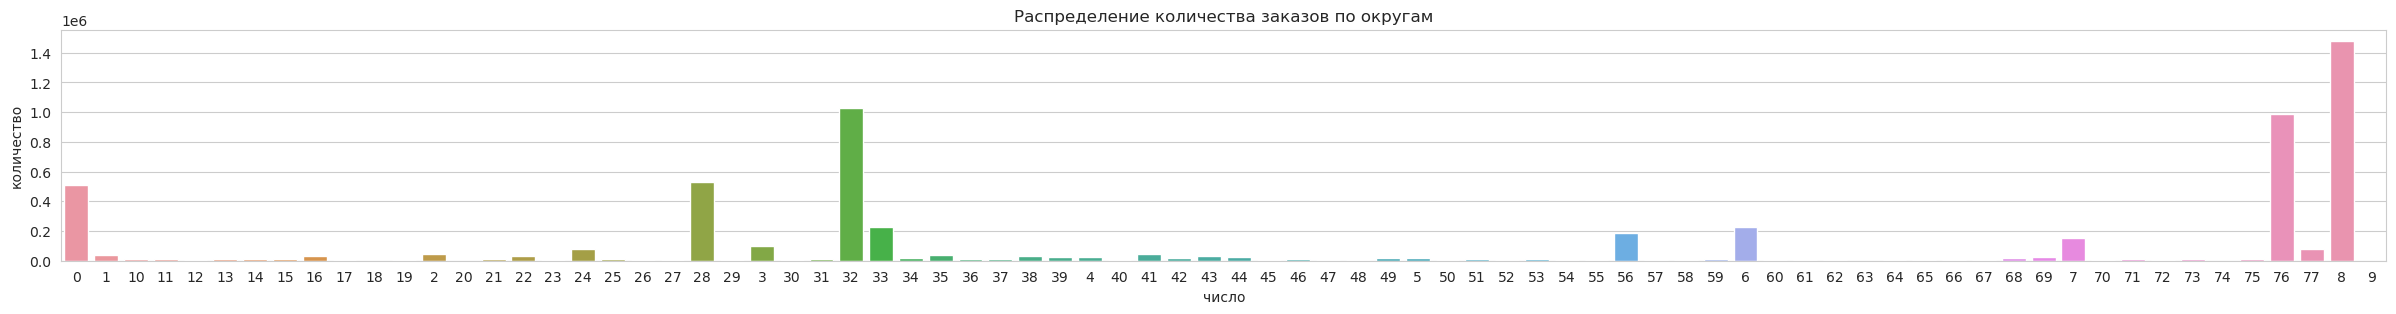

In [29]:
plt.figure(figsize=(30, 3))
sns.barplot(data=sort_area, x='Pickup_Community_Area', y='count')
plt.xlabel('число')
plt.ylabel('количество')
plt.title('Распределение количества заказов по округам');

In [30]:
sort_area.sort_values(by='count', ascending=False)

,Pickup_Community_Area,count
76,8,1481245
26,32,1030319
74,76,989210
21,28,530927
0,0,512987
...,...,...
13,20,1172
77,9,1126
60,63,1038
10,18,754


***Выводы:***
из визуализации и таблицы видно, что максимальное количество заказов приходится на 8, 32 и 76 округа.

***3)*** Также я сгруппирую данные по временной метки начала поездки и визуализирую имеющиеся зависимости при помощи метода seasonal_decompose.

In [31]:
grouped = raw_df.groupBy('Trip_Start_Timestamp')

In [32]:
for_decompose = grouped.sum('num_orders').toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [33]:
for_decompose.index = for_decompose['Trip_Start_Timestamp']

In [34]:
for_decompose = for_decompose.drop('Trip_Start_Timestamp', axis=1)

In [35]:
for_decompose.sort_index(inplace=True)

In [36]:
decompose = for_decompose.resample('1H').sum()

In [37]:
decomposed = seasonal_decompose(decompose)

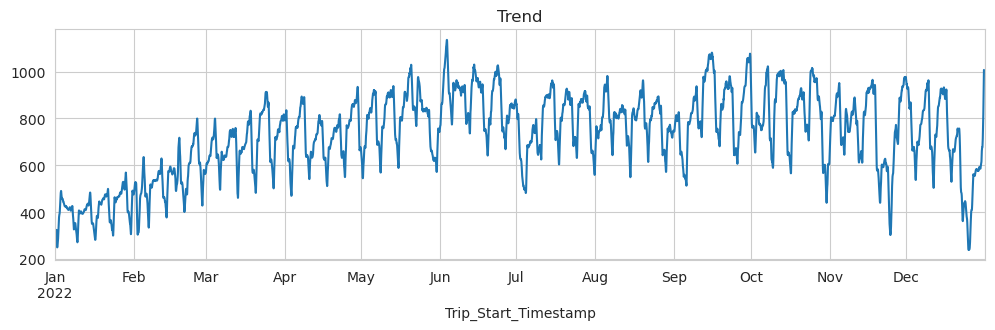

In [38]:
plt.figure(figsize=(12,3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

In [39]:
decomposed_01=seasonal_decompose(decompose['2022-01-25':'2022-01-26'])
decomposed_02=seasonal_decompose(decompose['2022-03-05':'2022-03-06'])
decomposed_03=seasonal_decompose(decompose['2022-05-10':'2022-05-11'])
decomposed_04=seasonal_decompose(decompose['2022-07-15':'2022-07-16'])
decomposed_05=seasonal_decompose(decompose['2022-10-20':'2022-10-21'])

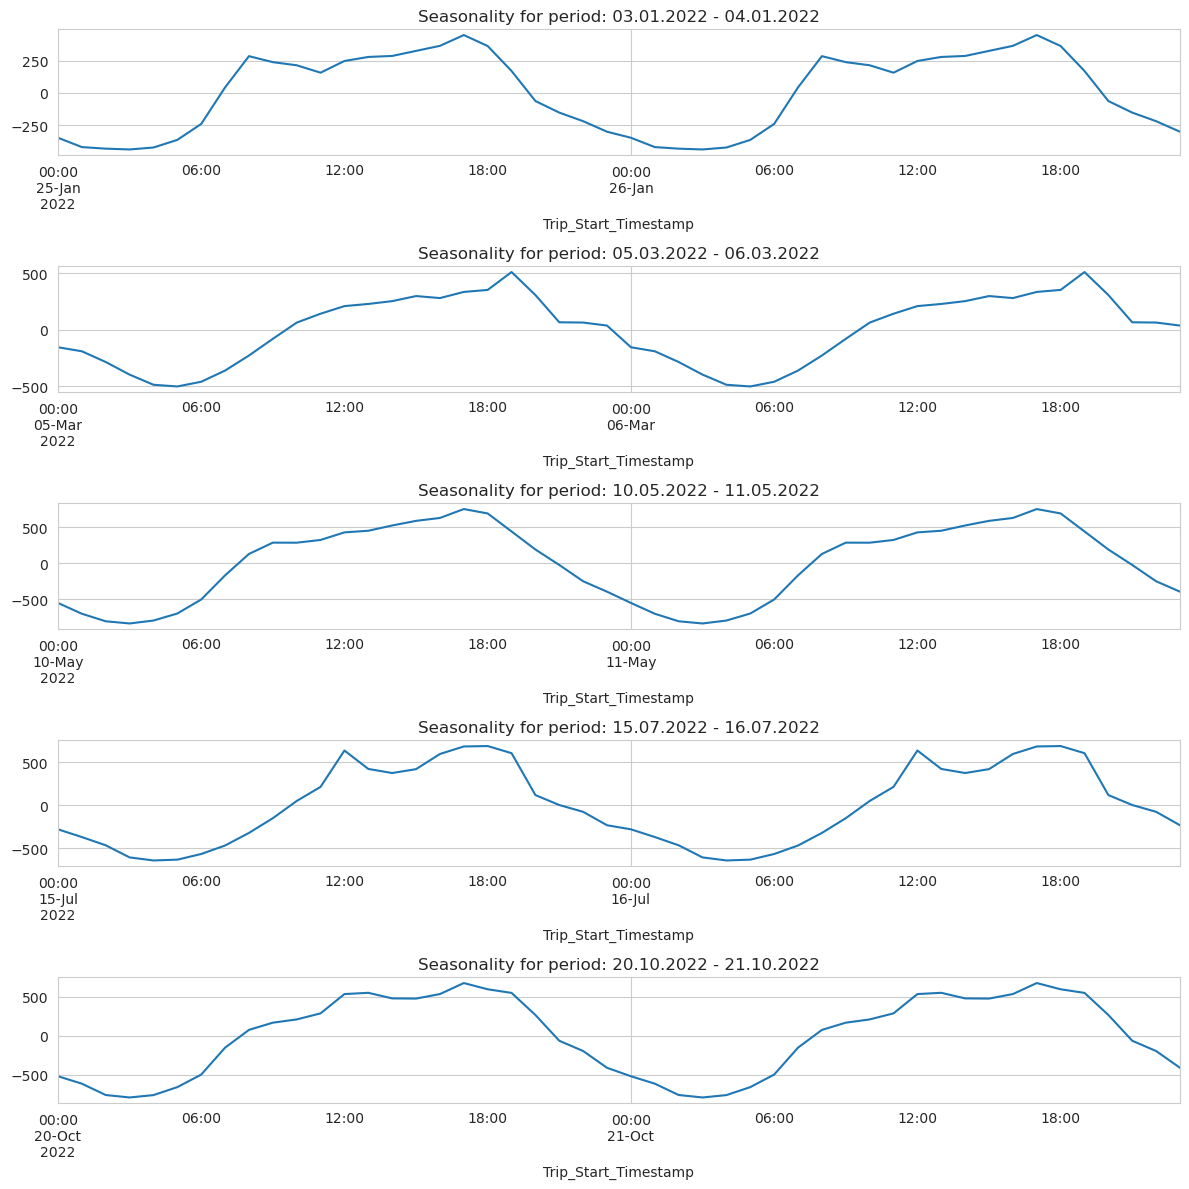

In [40]:
plt.figure(figsize=(12,12))
plt.subplot(511)
decomposed_01.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for period: 03.01.2022 - 04.01.2022')
plt.subplot(512)
decomposed_02.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for period: 05.03.2022 - 06.03.2022')
plt.subplot(513)
decomposed_03.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for period: 10.05.2022 - 11.05.2022')
plt.subplot(514)
decomposed_04.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for period: 15.07.2022 - 16.07.2022')
plt.subplot(515)
decomposed_05.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for period: 20.10.2022 - 21.10.2022')

plt.tight_layout();

In [41]:
def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()
    return

In [42]:
decompose = decompose.rename(columns={'sum(num_orders)': 'num_orders'})

Критерий Дики-Фуллера: p=0.000001


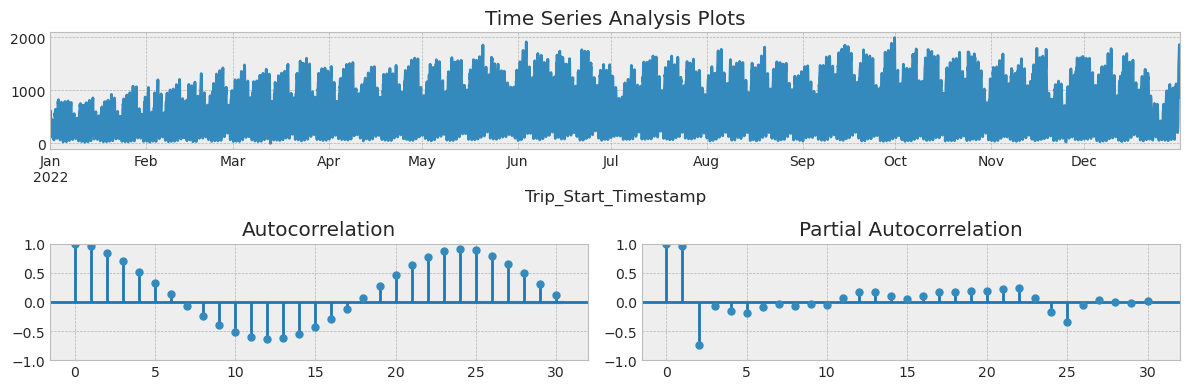

In [43]:
tsplot(decompose.num_orders, lags=30)

***Выводы:***
1) анализ, проведенный при помощи метода decompose, подтверждает выводы, сделанные выше, пик заказов приходится на июнь, минимум на январь
2) по визуализациям распределения количества заказов в течение суток за случайно выбранный период в разные даты и месяца можно сделать вывод, что несмотря на имеющиеся незначительные смещения, распределения количества заказов в сутки одинаково:
максимум в 18.00, минимум в 03.00
3) графики распределения количества заказов в течении суток показывают, что колебания целевой переменной практически во всех случаях укладывается в интервал равный 12 часам

***Разведовательный анализ имеющихся численных данных:***

In [44]:
raw_df[num_cols].summary().toPandas()

,summary,Trip_Seconds,Trip_Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,Tolls,Extras,Trip_Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,count,6377542,6377542,2621740,2673242,6377542,6377542,6377542,6377542,6377542,5866849,5866849,5780569,5780569
1,mean,1198.26768933862,6.183744983940213,1.7031468119334538E10,1.703141177007121E10,21.720614575327566,2.7549569023868603,0.02128830820722091,2.1631634742552506,26.816956234753533,41.89991655075763,-87.68815673633722,41.89470497231242,-87.66247362297797
2,stddev,1895.7587118974643,7.898731597340202,368917.9457484936,345703.76204903895,49.116291796317135,4.084056337750163,7.6607476886606864,21.75484103658861,56.70633144038878,0.06015188321232959,0.10469955837192053,0.05620230042298064,0.07330536649070095
3,min,0.0,0.0,1.70310103E10,1.70310103E10,0.0,0.0,0.0,0.0,0.0,41.65192,-87.91363,41.660137,-87.91363
4,25%,458.0,0.85,1.7031082E10,1.7031082E10,8.0,0.0,0.0,0.0,10.0,41.878864,-87.68384,41.878864,-87.66352
5,50%,862.0,2.6,1.70313206E10,1.70313206E10,14.0,0.92,0.0,0.0,17.0,41.893215,-87.63331,41.89251,-87.63331
6,75%,1620.0,11.1,1.70318408E10,1.70318387E10,33.25,4.0,0.0,2.0,40.5,41.944225,-87.62519,41.922688,-87.62519
7,max,86341.0,2967.54,1.703198E10,1.703198E10,9900.26,496.0,6666.66,8888.88,9900.31,42.021225,-87.530716,42.021225,-87.53139


In [45]:
raw_df.createOrReplaceTempView('table')

In [46]:
print('Средние значения численных признаков, сгруппированные по часам начала поездки')
spark.sql("""
    select Pickup_Community_Area as area, round(mean(Trip_Seconds)) as Time, round(mean(Trip_Miles)) as Miles, round(mean(Fare)) as Fare,
        round(mean(Tips)) as Tips, round(mean(Extras)) as Extras, mean(Tolls) as Tolls, round(mean(Trip_Total)) as Total
    from table
    group by Pickup_Community_Area
    order by Pickup_Community_Area
    """).show(24)

Средние значения численных признаков, сгруппированные по часам начала поездки
+----+------+-----+----+----+------+--------------------+-----+
|area|  Time|Miles|Fare|Tips|Extras|               Tolls|Total|
+----+------+-----+----+----+------+--------------------+-----+
|   0|1626.0| 11.0|33.0| 5.0|   5.0|0.016024577614783327| 43.0|
|   1|1513.0|  6.0|22.0| 1.0|   0.0| 0.01186218871837365| 23.0|
|  10|1461.0|  7.0|25.0| 1.0|   1.0|0.006816482198989969| 27.0|
|  11|1251.0|  6.0|22.0| 1.0|   1.0|0.002536281289481...| 24.0|
|  12|1686.0|  8.0|26.0| 1.0|   0.0|                 0.0| 27.0|
|  13|1478.0|  4.0|18.0| 0.0|   1.0|0.005853152956212...| 20.0|
|  14|1438.0|  5.0|20.0| 1.0|   0.0|8.210718914045106E-4| 21.0|
|  15|1295.0|  5.0|19.0| 1.0|   1.0|0.006393952483781...| 20.0|
|  16|1174.0|  4.0|18.0| 1.0|   1.0|0.032399633660892005| 20.0|
|  17|1590.0|  7.0|29.0| 1.0|   1.0|                 0.0| 30.0|
|  18|1934.0|  7.0|27.0| 0.0|   0.0|                 0.0| 27.0|
|  19|1943.0|  6.0|24.0| 0

In [47]:
num_feat = raw_df.groupBy('Pickup_Community_Area')\
.agg(round(F.mean('Trip_Seconds')).alias('Длительность'),
    round(F.mean('Trip_Miles')).alias('Дальность'),
    round(F.mean('Fare')).alias('Стоимость'),
    round(F.mean('Extras')).alias('Доп.расходы'),
    round(F.mean('Tips')).alias('Чаевые'),
    F.mean('Tolls').alias('Сборы'),
    round(F.mean('Trip_Total')).alias('Итог.стоим.')
    ).orderBy('Pickup_Community_Area').toPandas()

/tmp/ipykernel_39164/114123777.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_feat.corr(),


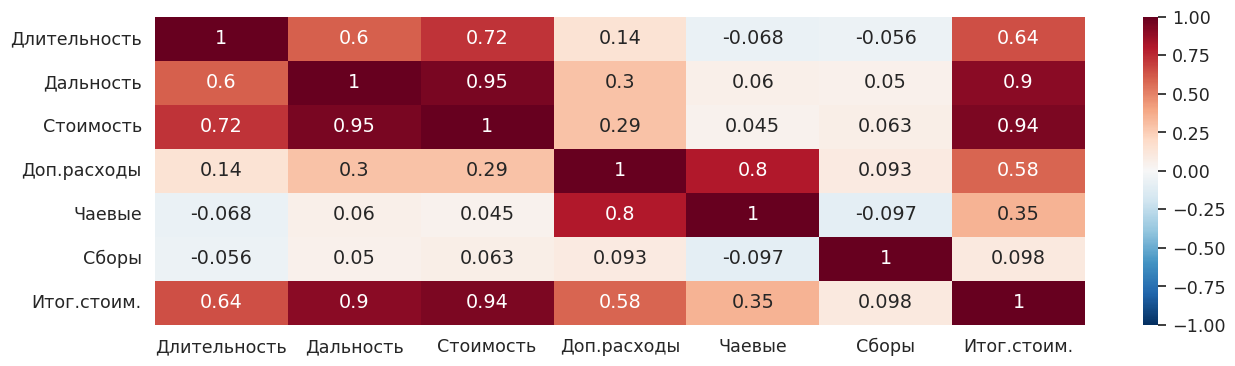

In [48]:
sns.set(font_scale=1.15)
plt.figure(figsize=(15,4))
sns.heatmap(
    num_feat.corr(),        
    cmap='RdBu_r', 
    annot=True,
    vmin=-1, vmax=1);

 - Видно, что средние показатели количественных признаков неравномерно распределены по округам, это поможет в будующем в предсказании количества поездок:
   - относительно средних финансовых показателей: заметна сильная корреляция между итоговой стоимостью поездки и ее составляющими, соответственно в признаки она включаться не будет
   - также заметна логичная взаимосвязь между фиансовыми показателями и средними данными по длительности и дальности поездок, эти признаки я также не буду включать в итоговый набор признаков
   - и наконец графа Сборы имеет крайне низкую взаимосвязь со всеми призаками и не войдет в итоговый набор.

***Разведовательный анализ некоторых категориальных данных:***

In [49]:
spark.sql('''
select distinct Company, count(Company) as count
from table
group by Company
order by count desc''').show(40)

+--------------------+-------+
|             Company|  count|
+--------------------+-------+
|           Flash Cab|1406011|
|Taxi Affiliation ...|1325872|
|            Sun Taxi| 717838|
|        City Service| 587808|
|Chicago Independents| 328276|
|Taxicab Insurance...| 284228|
|    Medallion Leasin| 266165|
|Taxicab Insurance...| 264850|
|          Globe Taxi| 241804|
|         5 Star Taxi| 157786|
|Star North Taxi M...| 152557|
|Blue Ribbon Taxi ...| 151942|
|Choice Taxi Assoc...| 126597|
| Top Cab Affiliation| 108904|
|           U Taxicab|  57818|
|       24 Seven Taxi|  55929|
|Blue Ribbon Taxi ...|  36977|
|     Chicago Taxicab|  24149|
|Patriot Taxi Dba ...|  21823|
|Koam Taxi Associa...|  12909|
|312 Medallion Man...|   9965|
|          Setare Inc|   6861|
|KOAM Taxi Associa...|   6076|
|   Metro Jet Taxi A.|   5557|
|             Top Cab|   4984|
|     Petani Cab Corp|   4033|
|3556 - 36214 RC A...|   2010|
|6574 - Babylon Ex...|   1488|
|4623 - 27290 Jay Kim|   1258|
|2733 - 

In [50]:
spark.sql('''
select distinct Payment_Type, count(Payment_Type) as count
from table
group by Payment_Type
order by count desc''').show(5)

+------------+-------+
|Payment_Type|  count|
+------------+-------+
| Credit Card|2480975|
|        Cash|2069379|
|      Mobile| 926509|
|      Prcard| 587000|
|     Unknown| 307227|
+------------+-------+
only showing top 5 rows



- Заметно, что существуют явные лидеры среди таксопарков по количеству перевозок за год, эти компании совершают более миллиона поездок за год(2 компании), 12 компаний осуществляют более ста тысяч поездок в год, 6 компаний более десяти тысяч, то есть примерно половина из представленных таксопарков осуществляет меньше десяти тысяч поезлок в год, что делает имеющиеся данные неравномерно разделенными по категории перевозчиков, поэтому я сделаю прогнозы на количество поездок в час для каждого округа для:
  - всех компаний(1 выборка)
  - крупнейшего автопарка - Flash Cab(2 выборка).

***Подготовка признаков для обучения***

- в этом разделе я сразу, воспользовавшись запросом spark.sql, создам выборку, включающую данные о времени начала поездки, месте ее начала, средние показатели данных о стоимости поездки и данные о количестве поездок для дальнейшей работы с моделью, для подвыборок 1 и 2 соответственно
- затем я отделю тестовую часть выбоки(последний час поездок)
- затем из имеющихся временных меток я получу дополнительные признаки для предсказаний: час, день недели, дату и месяц. Проведу лаггирование количества поездок. Также необходимо посчитать скользящее среднее для наших данных для создания еще одного признака. Данные о месте посадки тоже выступят в роли категориального признака.

In [51]:
temp1 = spark.sql('''
select Pickup_Community_Area as area, Trip_Start_Timestamp,
    sum(num_orders) as num_orders, round(mean(Fare), 2) as mean_fare, round(mean(Extras), 2) as mean_extras,
    round(mean(Tips), 2) as mean_tips
from table
group by Pickup_Community_Area, Trip_Start_Timestamp
order by Trip_Start_Timestamp''')

In [52]:
temp2 = spark.sql('''
select Pickup_Community_Area as area, Trip_Start_Timestamp,
    sum(num_orders) as num_orders, round(mean(Fare), 2) as mean_fare, round(mean(Extras), 2) as mean_extras,
    round(mean(Tips), 2) as mean_tips
from table
where Company == 'Flash Cab'
group by Pickup_Community_Area, Trip_Start_Timestamp
order by Trip_Start_Timestamp''')

In [53]:
temp_test1 = temp1.filter(col('Trip_Start_Timestamp')>=lit('2022-12-31 23:00:00'))
temp1 = temp1.filter(col('Trip_Start_Timestamp')<lit('2022-12-31 23:00:00'))
temp_test2 = temp2.filter(col('Trip_Start_Timestamp')>=lit('2022-12-31 23:00:00'))
temp2 = temp2.filter(col('Trip_Start_Timestamp')<lit('2022-12-31 23:00:00'))

- в наших данных присутствуют не все временные метки за 2022 год, необходимо их восстановить. Для этого я создам датафрейм со всеми почасовыми интервалами за 2022 год для всех округов, а потом соединю два датафрейма.

In [54]:
temp_grid = spark.sql('''
SELECT sequence(to_timestamp('2022-01-01 00:00:00'), to_timestamp('2022-12-31 23:45:00'),
interval '00 01:00:00' day to second) as clear_time, sequence(1, 78, 1) as clear_area
''')

In [55]:
clear_time = temp_grid.select(explode(temp_grid.clear_time).alias('Trip_Start_Timestamp'))
clear_area = temp_grid.select(explode(temp_grid.clear_area).alias('area'))

In [56]:
grid = clear_time.crossJoin(clear_area)

In [57]:
data1 = grid.join(temp1, how='left', on=['Trip_Start_Timestamp', 'area'])

In [58]:
data2 = grid.join(temp2, how='left', on=['Trip_Start_Timestamp', 'area'])

In [59]:
data1.filter(data1.num_orders.isNull()).count()

467137

- так как в данных образовались пропуски, заполню их нолями
- посчитаю лаги и скользящие средние для таргета и финансовых признаков
- выделю из временной метки час, дату, число и месяц.

In [60]:
data1 = data1.na.fill(0)

In [61]:
data2 = data2.na.fill(0)

In [62]:
data1 = data1.orderBy('Trip_Start_Timestamp')

In [63]:
data2 = data2.orderBy('Trip_Start_Timestamp')

In [64]:
w = Window.partitionBy('area').orderBy('Trip_Start_Timestamp')

In [65]:
for i in [1, 6, 24, 48, 12*30]:
    data1 = data1.withColumn('lag_{}_target'.format(i), F.lag("num_orders", i).over(w))
    data1 = data1.withColumn('lag_{}_fare'.format(i), F.lag("mean_fare", i).over(w))
    data1 = data1.withColumn('lag_{}_extras'.format(i), F.lag("mean_extras", i).over(w))
    data1 = data1.withColumn('lag_{}_tips'.format(i), F.lag("mean_tips", i).over(w))

In [66]:
for i in [1, 6, 24, 48, 12*30]:
    data2 = data2.withColumn('lag_{}_target'.format(i), F.lag("num_orders", i).over(w))
    data2 = data2.withColumn('lag_{}_fare'.format(i), F.lag("mean_fare", i).over(w))
    data2 = data2.withColumn('lag_{}_extras'.format(i), F.lag("mean_extras", i).over(w))
    data2 = data2.withColumn('lag_{}_tips'.format(i), F.lag("mean_tips", i).over(w))

In [67]:
data1 = data1.orderBy('Trip_Start_Timestamp')

In [68]:
data2 = data2.orderBy('Trip_Start_Timestamp')

In [69]:
w = Window.rowsBetween(-144, Window.currentRow)

In [70]:
data1 = data1.withColumn('mov_avg_target', F.round(F.avg("lag_1_target").over(w)))
data1 = data1.withColumn('mov_avg_fare', F.round(F.avg("lag_1_fare").over(w)))
data1 = data1.withColumn('mov_avg_extras', F.round(F.avg("lag_1_extras").over(w)))
data1 = data1.withColumn('mov_avg_tips', F.round(F.avg("lag_1_tips").over(w)))

In [71]:
data2 = data2.withColumn('mov_avg_target', F.round(F.avg("lag_1_target").over(w)))
data2 = data2.withColumn('mov_avg_fare', F.round(F.avg("lag_1_fare").over(w)))
data2 = data2.withColumn('mov_avg_extras', F.round(F.avg("lag_1_extras").over(w)))
data2 = data2.withColumn('mov_avg_tips', F.round(F.avg("lag_1_tips").over(w)))

In [72]:
data1 = data1.dropna()
data2 = data2.dropna()

In [73]:
data1 = data1.orderBy('Trip_Start_Timestamp')
data2 = data2.orderBy('Trip_Start_Timestamp')

In [74]:
data1 = data1.withColumn('hour', F.hour('Trip_Start_Timestamp'))
data1 = data1.withColumn('day_week', F.dayofweek('Trip_Start_Timestamp'))
data1 = data1.withColumn('day_month', F.dayofmonth('Trip_Start_Timestamp'))
data1 = data1.withColumn('month', F.month('Trip_Start_Timestamp'))
data1 = data1.withColumn('day_year', F.dayofyear('Trip_Start_Timestamp'))

In [75]:
data2 = data2.withColumn('hour', F.hour('Trip_Start_Timestamp'))
data2 = data2.withColumn('day_week', F.dayofweek('Trip_Start_Timestamp'))
data2 = data2.withColumn('day_month', F.dayofmonth('Trip_Start_Timestamp'))
data2 = data2.withColumn('month', F.month('Trip_Start_Timestamp'))
data2 = data2.withColumn('day_year', F.dayofyear('Trip_Start_Timestamp'))

- Теперь проведу работу с признаками, подготовив их к обучению:
  - из всех выборок я уберу натуральные значения финансовых показателей, оставив только их лаги и средние
  - закодирую категориальный признак, предварительно его заиндексировав
  - векторизирую и стандартизирую количественные. Но сперва разделю данные на обучающую и валидационную части.

In [76]:
nums = ['lag_1_target', 'lag_1_fare', 'lag_1_extras', 'lag_1_tips', 'lag_6_target', 'lag_6_fare', 'lag_6_extras',
 'lag_6_tips', 'lag_24_target', 'lag_24_fare', 'lag_24_extras', 'lag_24_tips', 'lag_48_target', 'lag_48_fare',
 'lag_48_extras', 'lag_48_tips', 'lag_360_target', 'lag_360_fare', 'lag_360_extras', 'lag_360_tips', 'mov_avg_target',
 'mov_avg_fare', 'mov_avg_extras', 'mov_avg_tips', 'hour', 'day_week', 'day_month', 'month', 'day_year']

In [77]:
valid1 = data1.filter((col('month') >= 11) & (col('Trip_Start_Timestamp')<lit('2022-12-31 23:00:00')))
valid2 = data2.filter((col('month') >= 11) & (col('Trip_Start_Timestamp')<lit('2022-12-31 23:00:00')))

In [78]:
train1 = data1.filter(col('month') < 11)
train2 = data2.filter(col('month') < 11)

In [79]:
indexer = StringIndexer(inputCol='area', outputCol="AreaIndex")
input = indexer.getOutputCol()

In [80]:
encoder = OneHotEncoder(inputCol=input, outputCol="AreaVec")

In [81]:
pipeline = Pipeline(stages=[indexer, encoder])

In [82]:
fits1 = pipeline.fit(train1)
train_ohe1 = fits1.transform(train1)
valid_ohe1 = fits1.transform(valid1)

In [83]:
fits2 = pipeline.fit(train2)
train_ohe2 = fits2.transform(train2)
valid_ohe2 = fits2.transform(valid2)

In [84]:
assembler = VectorAssembler(inputCols=nums, outputCol='num_features')

In [85]:
scaler = StandardScaler(inputCol='num_features', outputCol='nums_scaled')

In [86]:
pipeline = Pipeline(stages=[assembler, scaler])

In [87]:
fts1 = pipeline.fit(train_ohe1)
train1 = fts1.transform(train_ohe1)
valid1 = fts1.transform(valid_ohe1)

In [88]:
fts2 = pipeline.fit(train_ohe2)
train2 = fts2.transform(train_ohe2)
valid2 = fts2.transform(valid_ohe2)

In [89]:
train1 = train1[['AreaVec', 'nums_scaled', 'num_orders']]
valid1 = valid1[['AreaVec', 'nums_scaled', 'num_orders']]
train2 = train2[['AreaVec', 'nums_scaled', 'num_orders']]
valid2 = valid2[['AreaVec', 'nums_scaled', 'num_orders']]

In [90]:
assembler = VectorAssembler(inputCols=['AreaVec', 'nums_scaled'], outputCol='features')

In [91]:
train1 = assembler.transform(train1)
valid1 = assembler.transform(valid1)
train2 = assembler.transform(train2)
valid2 = assembler.transform(valid2)

***Валидация***
- На валидации я обучу несколько моделей(линейной регрессии, случайного леса в регрессии и бустинг), затем выберу из них лучшую.

In [92]:
lr1 = LinearRegression(featuresCol='features', labelCol='num_orders', predictionCol='preds', maxIter=100, regParam=0,
                      standardization=False)
lr_model1 = lr1.fit(train1)
predictions1 = lr_model1.transform(valid1)

In [93]:
lr2 = LinearRegression(featuresCol='features', labelCol='num_orders', predictionCol='preds', maxIter=100, regParam=0,
                      standardization=False)
lr_model2 = lr2.fit(train2)
predictions2 = lr_model2.transform(valid2)

In [94]:
pred_labels1 = predictions1.select('num_orders', 'preds')

In [95]:
pred_labels2 = predictions2.select('num_orders', 'preds')

In [96]:
lr_model1.coefficients

DenseVector([0.263, 0.1155, 0.0954, 0.0691, 0.0708, 0.0988, 0.0772, 0.1794, 0.0065, 0.0053, 0.0329, 0.296, -0.0052, 0.107, 0.1972, 0.0437, 0.3345, 0.1451, 0.0213, 0.0557, 1.6077, 0.0533, 0.4219, 0.0403, 0.0826, 3.089, 0.8242, 0.1443, 0.2182, 0.114, 0.0999, 0.2266, 0.1922, 0.1507, 0.0605, 0.2476, 0.1635, 0.269, 0.2397, 0.0526, 0.1428, 0.0145, 0.0734, 0.1637, 0.099, 0.0812, 0.094, 0.0448, 0.1333, 0.0386, 0.0402, 0.7266, 0.0076, 0.0133, 0.0599, 0.765, 0.0357, 0.056, 0.0027, -0.0012, 0.01, 0.0201, 0.0614, 0.0707, 0.144, 0.2099, 0.5359, 0.0445, 0.1011, 0.0394, 0.1239, -0.0, 0.1122, 3.1523, 0.3588, -0.0169, 4.3433, 5.4671, -0.1872, -0.007, 0.0284, -0.683, 0.0099, 0.0013, -0.012, 2.0759, -0.0513, -0.0015, 0.0165, 0.0772, 0.0172, -0.0038, 0.0314, 1.0347, -0.0203, -0.0028, 0.0076, -0.0382, 0.1477, 0.002, 0.0194, -0.0476, -0.0279, 0.1156, 1.1246, -1.1138])

In [97]:
lr_model2.coefficients

DenseVector([0.2717, 0.0873, 0.0628, 0.0566, 0.048, 0.0658, 0.0359, 0.1207, 0.0046, -0.0004, 0.0167, 0.294, -0.0056, 0.0557, 0.1501, 0.0304, 0.2438, 0.1397, 0.0183, 0.0496, 0.7415, 0.0318, 0.3806, 0.0231, 0.0536, 1.116, 0.4491, 0.0987, 0.1626, 0.0607, 0.0769, 0.1748, 0.133, 0.1512, 0.0363, 0.1726, 0.1204, 0.2619, 0.2134, 0.0411, 0.1139, 0.0098, 0.073, 0.1436, 0.0784, 0.0582, 0.0922, 0.0357, 0.103, 0.0455, 0.0487, 0.187, 0.0072, 0.0056, 0.0273, 0.5732, 0.0134, 0.0322, -0.0044, -0.0039, 0.0015, 0.0037, 0.0448, 0.0424, 0.1089, 0.1933, 0.377, 0.0303, 0.0776, 0.0377, 0.1073, 0.0011, 0.0861, 0.9625, 0.3463, -0.0127, 1.695, 0.5816, -0.1092, 0.0005, 0.0109, -0.0058, -0.0057, -0.0093, 0.0031, 0.3612, -0.0436, 0.0064, 0.0001, 0.1676, -0.0096, 0.0081, -0.0007, 0.2924, -0.0345, 0.0031, 0.0007, 0.0071, 0.0801, -0.0052, 0.004, -0.0154, -0.003, 0.0247, 0.2304, -0.2363])

In [98]:
lr_model1.intercept

-0.6067135972711744

In [99]:
lr_model2.intercept

-0.21421246501324598

In [100]:
lr_model1.summary.meanAbsoluteError

0.8818348348545475

In [101]:
lr_model2.summary.meanAbsoluteError

0.3899961175081764

In [102]:
evaluator = RegressionEvaluator(predictionCol='preds', labelCol='num_orders', metricName='mae')

In [103]:
evaluator.evaluate(pred_labels1)

0.9035091758250478

In [104]:
evaluator.evaluate(pred_labels2)

0.3473321778994512

- для случайного леса сначала подберем количество деревьев, соответствующих максимальной r2

In [105]:
def mllib_random_forest(train, test, trees, target_col='num_orders'):
    rf = RandomForestRegressor(numTrees=trees, labelCol=target_col)
    model = rf.fit(train)
    
    pred = model.transform(test)
    r = pred.stat.corr("prediction", target_col)
    
    return [trees, r**2]

In [106]:
parameters = [10, 20, 50]

In [107]:
pool = ThreadPool(5)
pool.map(
    lambda trees: mllib_random_forest(train1, valid1, trees), 
    parameters
)

[[10, 0.8951187024131139], [20, 0.8950511808687378], [50, 0.8975571142283694]]

- максимальное значение r2 соответствует 50-ти деревьям и в первом и во втором случаях.

In [108]:
rf = RandomForestRegressor(numTrees=50, labelCol='num_orders', featuresCol='features', predictionCol='preds')
model1 = rf.fit(train1)
predictions1 = model1.transform(valid1)

In [109]:
model2 = rf.fit(train2)
predictions2 = model2.transform(valid2)

In [110]:
pred_labels1 = predictions1.select('num_orders', 'preds')
evaluator.evaluate(pred_labels1)

0.9735866699724802

In [111]:
pred_labels2 = predictions2.select('num_orders', 'preds')
evaluator.evaluate(pred_labels2)

0.36885670916956265

In [112]:
regressor = GBTRegressor(
    labelCol="num_orders",
    featuresCol="features",
    lossType="absolute",
    predictionCol='preds',
    maxIter=100, seed=random_state)

In [113]:
gbt_model1 = regressor.fit(train1)

In [114]:
gbt_model2 = regressor.fit(train2)

In [115]:
pred1 = gbt_model1.transform(valid1)
pred2 = gbt_model2.transform(valid2)

In [116]:
preds_labels1 = pred1.select('num_orders', 'preds')
evaluator.evaluate(preds_labels1)

0.8927854079702957

In [117]:
preds_labels2 = pred2.select('num_orders', 'preds')
evaluator.evaluate(preds_labels2)

0.3107715081614336

- лучшие результаты показала модель градиентного бустинга, на ней я и проведу тестирование подвыборок.

***Тестирование:***

- для тестирования подготовлю тестовую выборку:
  - обработаю отложенную тестовую часть(1 час), выбрав из нее только таргет и округ и соединив ее с "сеткой" из полного набора временных меток для всех округов, все пропуски заполню нолями
  - к ней присоединю получивчившиеся лаги и скользящие-средние значения
  - закодирую и отмасштабирую признаки
- проведу тестирование лучшей модели

In [118]:
test1 = data1.filter(col('Trip_Start_Timestamp')>='2022-12-31 23:00:00')

In [119]:
test2 = data2.filter(col('Trip_Start_Timestamp')>='2022-12-31 23:00:00')

In [120]:
test1 = test1.orderBy('area')

In [121]:
test2 = test2.orderBy('area')

In [122]:
temp_test1.createOrReplaceTempView('test_table1')

In [123]:
temp_test2.createOrReplaceTempView('test_table2')

In [124]:
temp1 = spark.sql('''
select area, sum(num) as num_orders
from
(select area, Trip_Start_Timestamp, 
    sum(num_orders) as num
from test_table1
group by area, Trip_Start_Timestamp
order by Trip_Start_Timestamp)
group by area
order by area
''')

In [125]:
temp2 = spark.sql('''
select area, sum(num) as num_orders
from
(select area, Trip_Start_Timestamp,
    sum(num_orders) as num
from test_table2
group by area, Trip_Start_Timestamp
order by Trip_Start_Timestamp)
group by area
order by area
''')

In [126]:
test_grid = spark.sql('''
SELECT sequence(1, 78, 1) as clear_area
''')

In [127]:
clear_area = test_grid.select(explode(test_grid.clear_area).alias('area'))

In [128]:
target1 = clear_area.join(temp1, how='left', on=['area']).orderBy('area')
target2 = clear_area.join(temp2, how='left', on=['area']).orderBy('area')

In [129]:
target1 = target1.na.fill(0)
target2 = target2.na.fill(0)

In [130]:
test1 = test1.drop('num_orders')
test2 = test2.drop('num_orders')

In [131]:
test1 = test1.join(target1, on='area', how='left').orderBy('area')
test2 = test2.join(target2, on='area', how='left').orderBy('area')

In [132]:
test_ohe1 = fits1.transform(test1)
test_ohe2 = fits2.transform(test2)

In [133]:
test1 = fts1.transform(test_ohe1)
test2 = fts2.transform(test_ohe2)

In [134]:
test1 = test1[['AreaVec', 'nums_scaled']]
test2 = test2[['AreaVec', 'nums_scaled']]

In [135]:
test1 = assembler.transform(test1)
test2 = assembler.transform(test2)

In [136]:
predictions1 = gbt_model1.transform(test1)

In [137]:
predictions2 = gbt_model2.transform(test2)

- Перенесу полученные предсказания и таргеты в пандас, чтобы посчитать метрики: MAE и SMAPE

In [138]:
pd_target1 = target1.toPandas()
pd_target2 = target2.toPandas()

In [139]:
pd_predictions1 = predictions1.toPandas()
pd_predictions2 = predictions2.toPandas()

In [140]:
pd_target1 = pd_target1[['num_orders']]
pd_target2 = pd_target2[['num_orders']]

In [141]:
pd_predictions1 = pd_predictions1[['preds']]
pd_predictions2 = pd_predictions2[['preds']]

In [142]:
pd_df1 = pd.concat([pd_target1, pd_predictions1], axis=1)
pd_df2 = pd.concat([pd_target2, pd_predictions2], axis=1)

In [143]:
from sklearn.metrics import mean_absolute_error

In [144]:
mean_absolute_error(pd_df1.num_orders, pd_df1.preds)

8.679169432664981

In [145]:
mean_absolute_error(pd_df2.num_orders, pd_df2.preds)

1.7126828341719489

In [146]:
sum((2*abs(pd_df1.num_orders- pd_df1.preds))/(abs(pd_df1.num_orders)+abs(pd_df1.preds)))/78

1.8274874168844195

In [147]:
sum((2*abs(pd_df2.num_orders- pd_df2.preds))/(abs(pd_df2.num_orders)+abs(pd_df2.preds)))/78

1.949590417449881

- Итого:
  - для всех перевозчиков средняя абсолютная ошибка составила 8.7, симметричная средняя абсолютная процентная ошибка - 1.8
  - для крупнейшего перевозчика - 1.7 и 1.95 соответственно.

In [148]:
spark.stop()